<a href="https://colab.research.google.com/github/jrjradler/twittersentimentmk1/blob/main/TwitterAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import lib
from textblob import TextBlob
from wordcloud import WordCloud
import numpy as np
import re
import matplotlib.pyplot as plt
import os
import tweepy
import pandas as pd
plt.style.use('fivethirtyeight')

In [42]:
#Importing the dataset
data_file = 'Bitcoin_tweets.csv'
df = pd.read_csv(data_file)
# Show the first 5 rows of data or the head (Fun Fact: There is also .tail() which shows the last 5 rows - zero indexed)
df.tail()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5,6,7,12) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
73737,Northstar,North East England,Professional Meteorologist. Applying statistic...,2019-02-17 19:09:27,38998.0,423,16925,False,2021-04-05 11:47:16,#Orchid (#OXT) attempting to push through resi...,"['Orchid', 'OXT', 'cryptocurrencies']",Twitter Web App,False
73738,Bitcoin updates,NaN,I tweet about the #Bitcoin price.\nData is ret...,2021-01-09 15:26:06,815.0,8,0,False,2021-04-05 11:47:04,The $BTC price is at $57642.34 right now.\n🟢 C...,NaN,DreamersApp,False
73739,CaptainScio 3 mo. 30 days til Full Time Trading,Planet Earth,Professional Trader/Financial Consultant Who W...,2013-12-11 23:19:53,2608.0,289,1707,False,2021-04-05 11:46:58,1) Good Morning! Primary Trend Is Up! Today Is...,"['BTC', 'BITCOIN']",Twitter Web App,False
73740,Bitcoin updates,NaN,I tweet about the #Bitcoin price.\nData is ret...,2021-01-09 15:26:06,815.0,8,0,False,2021-04-05 11:45:58,The $BTC price is at $57641.69 right now.\n🟢 C...,NaN,DreamersApp,False
73741,Crypto Wizard 🧙‍♂️,Planet Earth (for now),.: Cryptocurrency Bull | Diverse Investor Sinc...,2021-03-31 18:09:29,57.0,67,734,False,2021-04-05 11:43:09,"In early Feb, just after their 2020 Q4 earning...",NaN,Twitter for iPhone,False


In [43]:
#First step in cleaning data is removing any unnecessary columns that don't provide us with value. I'm only looking at text here, so everything else needs to be removed.
df.drop(labels=['user_name','user_location','user_description','user_created','user_followers','user_friends','user_favourites','user_verified','date','hashtags','source','is_retweet'],inplace=True,axis=1)

In [44]:
#For smplicity I changed the 'text' column to 'Tweets'.
df.columns = ['Tweets']
df.head() #Helped me confirm that the column was indeed changed.


,Tweets
0,Blue Ridge Bank shares halted by NYSE after #b...
1,"😎 Today, that's this #Thursday, we will do a ""..."
2,"Guys evening, I have read this article about B..."
3,$BTC A big chance in a billion! Price: \487264...
4,This network is secured by 9 508 nodes as of t...


In [45]:
# Create a function to clean the tweets
def cleanTxt(text):
 text = re.sub('@[A-Za-z0–9]+', '', str(text)) #Removing @mentions
 text = re.sub('#', '', str(text)) # Removing '#' hash tag
 text = re.sub('RT[\s]+', '', str(text)) # Removing RT
 text = re.sub('https?:\/\/\S+', '', str(text)) # Removing hyperlink
 text = re.sub('\r\n|\n|\r/gm', '', str(text)) #Removes misc charecter/s
 text = re.sub('@', '', str(text)) #Removes misc charecter/s
 text = re.sub(':', '', str(text)) #Removes misc charecter/s
 
 return text


def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F7E2" # The one green dot emoji everyone loves
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)
    #Not entirely neccesary, but Textblob doesn't consider emojis, so it's a matter of cleaner data.


# Clean the tweets/apply filters
df['Tweets'] = df['Tweets'].apply(cleanTxt)
df['Tweets'] = df['Tweets'].apply(deEmojify)

# Show the cleaned tweets
df

,Tweets
0,Blue Ridge Bank shares halted by NYSE after bi...
1,"Today, that's this Thursday, we will do a "" T..."
2,"Guys evening, I have read this article about B..."
3,$BTC A big chance in a billion! Price \4872644...
4,This network is secured by 9 508 nodes as of t...
...,...
73737,Orchid (OXT) attempting to push through resist...
73738,The $BTC price is at $57642.34 right now. Comp...
73739,1) Good Morning! Primary Trend Is Up! Today Is...
73740,The $BTC price is at $57641.69 right now. Comp...


In [46]:
# Create a function to get the subjectivity
def getSubjectivity(text):
   return TextBlob(text).sentiment.subjectivity #Subjectivity < 1  but > 0 is more factual, > 1 is very opinionated (0 and +1 are min/max)

# Create a function to get the polarity
def getPolarity(text):
   return  TextBlob(text).sentiment.polarity #Polarity < 0 is more negative, > 0 is more positive (-1 and +1 are the min/max)


# Create two new columns 'Subjectivity' & 'Polarity'
df['Subjectivity'] = df['Tweets'].apply(getSubjectivity)
df['Polarity'] = df['Tweets'].apply(getPolarity)

# Show the new dataframe with columns 'Subjectivity' & 'Polarity'
df



,Tweets,Subjectivity,Polarity
0,Blue Ridge Bank shares halted by NYSE after bi...,0.10000,0.000000
1,"Today, that's this Thursday, we will do a "" T...",0.00000,0.000000
2,"Guys evening, I have read this article about B...",0.00000,0.000000
3,$BTC A big chance in a billion! Price \4872644...,0.10000,0.000000
4,This network is secured by 9 508 nodes as of t...,0.10000,0.000000
...,...,...,...
73737,Orchid (OXT) attempting to push through resist...,0.10000,0.700000
73738,The $BTC price is at $57642.34 right now. Comp...,0.30119,0.142857
73739,1) Good Morning! Primary Trend Is Up! Today Is...,0.43125,0.250000
73740,The $BTC price is at $57641.69 right now. Comp...,0.30119,0.142857


In [47]:
# word cloud visualization just for fun!
allWords = ' '.join([twts for twts in df['Tweets']])
wordCloud = WordCloud(width=500, height=300, random_state=21, max_font_size=110).generate(allWords)


plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()


KeyboardInterrupt: ignored

In [48]:
# Create a function to compute negative (-1), neutral (0) and positive (+1) analysis /tweet
def getAnalysis(score):

  if score < 0:
    return 'Negative'
  elif score == 0:
    return 'Neutral'
  else:
    return 'Positive'
df['Analysis'] = df['Polarity'].apply(getAnalysis)


In [49]:
# Printing positive tweets (optinonal)
print('Printing positive tweets:\n')
j=1
sortedDF = df.sort_values(by=['Polarity']) #Sort the tweets
for i in range(0, sortedDF.shape[0] ):
  if( sortedDF['Analysis'][i] == 'Neutral'):
    print(str(j) + ') '+ sortedDF['Tweets'][i])
    print()
    j= j+1


#I seeminlgy failed to remove some emojis (fix this later- checkmark, peace signs, arrows, face emojis)

Streaming output truncated to the last 5000 lines.
35035) Earn bitcoins while surfing the web!   cryptotab bitcoin  bitcoins btc  crypto income… 

35036) Crypto prices | 1200 PM | 4/6/21  Bitcoin BTC $BTC Ethereum ETH Tether USDT… 

35037) Quietly, in the background, without causing a fuss, doing my bit....I always was the school computer nerd in the… 

35038) Adonexchange ADN $ADN ADON bitcoin cryptocurrency blockchain DeFi bounty money btc cryptotrading… 

35039) 1 BTC Price Bitstamp 57801.32 USD Coinbase  USD btc bitcoin 2021-04-06 1201 

35040) ethereum eth ripple xrp ada litecoin ltc eos xlm trx dash xmr BTC BITCOIN $IOTA $MIOTA $ADA $XRP… 

35041) Bitcoin - BTCPrice $58,082.92Change in 1h -0.92071599%Market cap $1,084,705,739,517.75Ranking 1Bitcoin BTC

35042) BitcoinPrice (Binance) $58026.27 (-0.19)%Dominance 56.92 (-0.12)%Calculated by TradingViewbtc altcoin $btc $alts

35043) ethereum eth ripple xrp cardano ada litecoin ltc eos xlm trx dash xmr BTC BITCOIN $IOTA $MIOTA $ADA… 


In [ ]:
# Printing negative tweets (optinonal)
print('Printing negative tweets:\n')
j=1
sortedDF = df.sort_values(by=['Polarity'],ascending=False) #Sort the tweets
for i in range(0, sortedDF.shape[0] ):
  if( sortedDF['Analysis'][i] == 'Negative'):
    print(str(j) + ') '+sortedDF['Tweets'][i])
    print()
    j=j+1

In [ ]:
# Plotting (optinonal and takes a lot of ram 💁)
plt.figure(figsize=(8,6)) 
for i in range(0, df.shape[0]):
  plt.scatter(df["Polarity"][i], df["Subjectivity"][i], color='Blue') 
# plt.scatter(x,y,color)   
plt.title('Sentiment Analysis') 
plt.xlabel('Polarity') 
plt.ylabel('Subjectivity') 
plt.show()

In [54]:
# Print the percentage of positive tweets
ptweets = df[df.Analysis == 'Positive']
ptweets = ptweets['Tweets']
ptweets = round( (ptweets.shape[0] / df.shape[0]) * 100 , 1)
print(ptweets)





40.3


In [55]:
# Print the percentage of negative tweets
ntweets= df[df.Analysis == 'Negative']
ntweets = ntweets['Tweets']
ntweets = round( (ntweets.shape[0] / df.shape[0]) * 100 , 1)
print(ntweets)

8.8


In [56]:
# Print the percentage of neutral tweets
netweets= df[df.Analysis == 'Neutral']
netweets = netweets['Tweets']
netweets = round( (netweets.shape[0] / df.shape[0]) * 100 , 1)
print(netweets)

50.9


In [38]:
if ptweets > ntweets:
  print("Positive Sentiment")
else:
  print("Negative Sentiment")
#If the data set is more positive then negative, then the overall sentiment is positive and vice versa.


Positive Sentiment


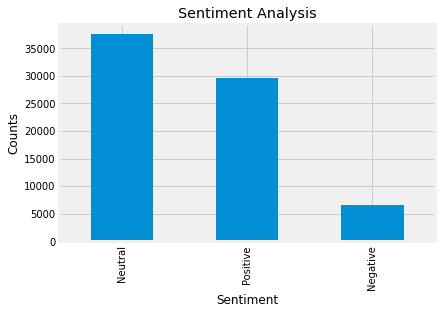

In [57]:
# Plotting and visualizing the counts to see the results
plt.title('Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
df['Analysis'].value_counts().plot(kind = 'bar')
plt.show()
#Way too much neutral sentiment, will add tokenization next.